# StyleGAN latent space exploration

## Install dependencies

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [2]:
%mkdir raw_images
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch
%cd stylegan2-ada-pytorch
!git clone https://github.com/denkogit/stylegan2_models

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 131 (delta 0), reused 1 (delta 0), pack-reused 128
Receiving objects: 100% (131/131), 1.13 MiB | 1.26 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/Users/pavelvyaznikov/Documents/itmo_gan_course/stylegan2-ada-pytorch
Cloning into 'stylegan2_models'...


/Users/pavelvyaznikov/Documents/itmo_gan_course/venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 57 (delta 14), reused 48 (delta 7), pack-reused 0
Receiving objects: 100% (57/57), 25.54 KiB | 25.54 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [6]:
!mkdir pretrained_models
%cd pretrained_models
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
!wget https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

/Users/pavelvyaznikov/Documents/itmo_gan_course/stylegan2-ada-pytorch/pretrained_models/pretrained_models/pretrained_models/pretrained_models
--2024-03-27 22:50:45--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Распознаётся nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)… 18.244.102.38, 18.244.102.51, 18.244.102.26, ...
Подключение к nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|18.244.102.38|:443... соединение установлено.


/Users/pavelvyaznikov/Documents/itmo_gan_course/venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 381624121 (364M) [binary/octet-stream]
Сохранение в: «ffhq.pkl»

ffhq.pkl            100%[===================>] 363,94M  13,6MB/s    за 28s     

2024-03-27 22:51:13 (13,2 MB/s) - «ffhq.pkl» сохранён [381624121/381624121]

--2024-03-27 22:51:13--  https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2
Распознаётся github.com (github.com)… 140.82.121.3
Подключение к github.com (github.com)|140.82.121.3|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://raw.githubusercontent.com/davisking/dlib-models/master/shape_predictor_68_face_landmarks.dat.bz2 [переход]
--2024-03-27 22:51:13--  https://raw.githubusercontent.com/davisking/dlib-models/master/shape_predictor_68_face_landmarks.dat.bz2
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Подключение к raw.githubusercontent.com (raw.

## Download images and vectors

## Align images

In [3]:
import os
from stylegan2_ada_pytorch.stylegan2_models.image_aligner.face_alignment import (
    image_align,
)
from stylegan2_ada_pytorch.stylegan2_models.image_aligner.landmarks_detector import (
    LandmarksDetector,
)


landmarks_model_path = (
    "stylegan2_ada_pytorch/pretrained_models/shape_predictor_68_face_landmarks.dat"
)
RAW_IMAGES_DIR = "14-celebrity-faces-dataset/data/train"
ALIGNED_IMAGES_DIR = "aligned_images"

landmarks_detector = LandmarksDetector(landmarks_model_path)
for celeb in os.listdir(RAW_IMAGES_DIR):
    celeb_folder = os.path.join(RAW_IMAGES_DIR, celeb)
    save_path = os.path.join(ALIGNED_IMAGES_DIR, celeb)
    os.makedirs(save_path, exist_ok=True)

    for i, img_name in enumerate(os.listdir(celeb_folder)):
        raw_img_path = os.path.join(celeb_folder, img_name)

        for face_landmarks in landmarks_detector.get_landmarks(raw_img_path):
            aligned_face_path = os.path.join(save_path, f"{i}.jpg")
            image_align(raw_img_path, aligned_face_path, face_landmarks)
            break

# StyleGAN face generation

## StyleGAN face generation

In [2]:
import os
os.chdir("stylegan2_ada_pytorch")
print(os.getcwd())


/Users/pavelvyaznikov/Documents/itmo_gan_course/stylegan2_ada_pytorch


In [3]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


def plot_image(tensor, plot_size=(10, 10)):
    tensor = (tensor.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    img = Image.fromarray(tensor[0].cpu().numpy(), "RGB")
    plt.rcParams["figure.figsize"] = plot_size
    plt.imshow(img)


def broadcast_w_sg(w_batch, cast_n=18):
    input_ws = []
    for w in w_batch:
        w_broadcast = torch.broadcast_to(w, (cast_n, 512))
        input_ws.append(w_broadcast)
        
    return torch.stack(input_ws)

In [84]:
seed = 2345645
noise_mode = 'const' # шум
label = 0 # для разных моделей
device = "mps"
model_path = "/Users/pavelvyaznikov/Documents/itmo_gan_course/stylegan2_ada_pytorch/pretrained_models/ffhq.pkl"

with open(model_path, 'rb') as f:
    G = pickle.load(f)['G_ema'].to("cpu")

## Projection of real images

Проекция это поиск точки в латентном пространстве которая визуально будет похожа на реальное изображение


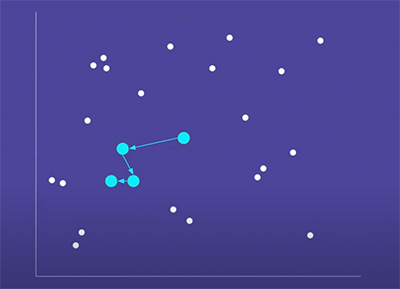

/Users/pavelvyaznikov/Documents/itmo_gan_course/aligned_images/keanu_reeves/3.jpg
/Users/pavelvyaznikov/Documents/itmo_gan_course/aligned_images/anne_hathaway/8.jpg
/Users/pavelvyaznikov/Documents/itmo_gan_course/aligned_images/sofia_vergara/11.jpg
/Users/pavelvyaznikov/Documents/itmo_gan_course/aligned_images/kate_beckinsale/9.jpg
/Users/pavelvyaznikov/Documents/itmo_gan_course/aligned_images/simon_pegg/9.jpg
/Users/pavelvyaznikov/Documents/itmo_gan_course/aligned_images/keanu_reeves/4.jpg

In [5]:
import PIL
import os
import numpy as np
import torch
import lpips
import torch.nn as nn
import torchvision.transforms as transforms
from pytorch_msssim import ms_ssim
from tqdm import tqdm
import torch.nn.functional as F
from PIL import Image


device = "mps"


# https://pypi.org/project/pytorch-msssim/
class Rec_loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_criterion = torch.nn.L1Loss(reduction="mean")

    def forward(self, target, synth):
        target = torch.add(target, 1.0)
        target = torch.mul(target, 127.5)
        target = target / 255

        synth = torch.add(synth, 1.0)
        synth = torch.mul(synth, 127.5)
        synth = synth / 255

        loss = torch.mean(1 - ms_ssim(synth, target, data_range=1, size_average=True))
        return loss


# https://pypi.org/project/lpips/
class Lpips_loss(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.lpips_loss = lpips.LPIPS(net="vgg")
        self.lpips_loss.to(device)
        self.lpips_loss.eval()

    def forward(self, target, synth):
        return torch.mean(self.lpips_loss(target, synth))


# https://github.com/NVlabs/stylegan2-ada-pytorch/blob/main/projector.py#L104
class Reg_loss(nn.Module):
    def __init__(self, noise_bufs):
        super().__init__()
        self.noise_bufs = noise_bufs

    def forward(
        self,
    ):
        reg_loss = 0.0
        for v in self.noise_bufs.values():
            noise = v[None, None, :, :]  # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise * torch.roll(noise, shifts=1, dims=3)).mean() ** 2
                reg_loss += (noise * torch.roll(noise, shifts=1, dims=2)).mean() ** 2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        return reg_loss


# image = (image - mean) / std
def image2tensor_norm(image):
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]
    )
    tensor = transform(image)
    return tensor


# загружаем изображение
inv_img_path = (
    "/Users/pavelvyaznikov/Documents/itmo_gan_course/aligned_images/keanu_reeves/3.jpg"
)
target_pil = Image.open(inv_img_path).convert("RGB")
target_tensor = image2tensor_norm(target_pil).to(device).unsqueeze(0)


# инициализируем функции потерь
lpips_loss = Lpips_loss(device)
rec_loss = Rec_loss()

noise_bufs = {
    name: buf for (name, buf) in G.synthesis.named_buffers() if "noise_const" in name
}
reg_loss = Reg_loss(noise_bufs)

#  loss weights
# regularize_noise_weight = 5e5
# rec_weight = 0.5
# lpips_weoght = 1
regularize_noise_weight = 5e5
rec_weight = 0.5
lpips_weoght = 1

# Параметры для оптимизации
num_steps = 150
seed = 42
initial_learning_rate = 0.05
w_avg_samples = 10000

# Получаем средний вектор латентного пространства
z_samples = (
    torch.from_numpy(np.random.RandomState(seed).randn(w_avg_samples, G.z_dim))
    .type(torch.float32)
    .to(device)
)
w_samples = G.mapping(z_samples, None)
w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)
w_avg = np.mean(w_samples, axis=0, keepdims=True)  # [1, 1, C]
w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

# w or w_plus
w_opt = torch.tensor(
    w_avg, dtype=torch.float32, device=device, requires_grad=False
)  # pylint: disable=not-callable
w_opt = broadcast_w_sg(w_opt).requires_grad_(True)

optimizer = torch.optim.Adam([w_opt], lr=initial_learning_rate)
generated_tensors = []
for step in tqdm(range(num_steps)):
    synth_tensor = G.synthesis(broadcast_w_sg(w_opt), noise_mode="const")

    lpips_value = lpips_loss(synth_tensor, target_tensor)
    rec_value = rec_loss(synth_tensor, target_tensor)
    reg_value = reg_loss()

    loss = (
        lpips_value * lpips_weoght
        + rec_value * rec_weight
        + reg_value * regularize_noise_weight
    )

    optimizer.step()
    optimizer.zero_grad(set_to_none=True)
    loss.backward()

    generated_tensors.append(synth_tensor)

generated_tensor = G.synthesis(
    broadcast_w_sg(w_opt), noise_mode="const", force_fp32=True
)

# save_image(generated_tensor, path="./projected_image.png")
print(loss.item())

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/Users/pavelvyaznikov/Documents/itmo_gan_course/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pavelvyaznikov/Documents/itmo_gan_course/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/pavelvyaznikov/Documents/itmo_gan_course/venv/lib/python3.11/site-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 150/150 [01:07<00:00,  2.22it/s]

114595.4453125


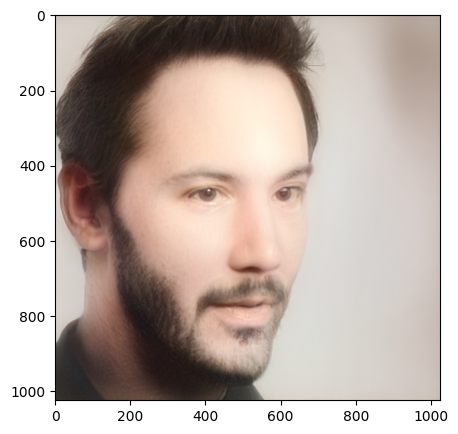

In [6]:
plot_image(generated_tensor, plot_size=(5,5))

In [36]:
import imageio


def save_video(video_path):
    video = imageio.get_writer(
        video_path, mode="I", fps=10, codec="libx264", bitrate="16M"
    )
    target_uint8 = np.array(target_pil, dtype=np.uint8)
    print(f"Saving optimization progress video {video_path}")
    for synth_image in generated_tensors:
        synth_image = (synth_image + 1) * (255 / 2)
        synth_image = (
            synth_image.permute(0, 2, 3, 1)
            .clamp(0, 255)
            .to(torch.uint8)[0]
            .cpu()
            .numpy()
        )
        video.append_data(np.concatenate([target_uint8, synth_image], axis=1))
    video.close()


video_path = "/Users/pavelvyaznikov/Documents/itmo_gan_course/proj_video.mp4"
save_video(video_path)

Saving optimization progress video /Users/pavelvyaznikov/Documents/itmo_gan_course/proj_video.mp4


### Encoder for editing

https://arxiv.org/pdf/2102.02766.pdf

Ld-reg - позволяет дельтам не расходиться

Ladv - Дискриминатор сравнивает латенты

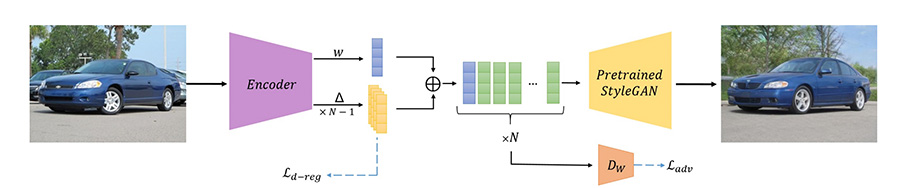

In [7]:
from stylegan2_ada_pytorch.stylegan2_models.e4e.model_utils import load_e4e_standalone
import torchvision.transforms as transforms

e4e_model, _ = load_e4e_standalone("pretrained_models/e4e_ffhq_encode.pt", device="mps")

image2e4etensor = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((256, 256)),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])


In [10]:
image_path = "/Users/pavelvyaznikov/Documents/itmo_gan_course/aligned_images/keanu_reeves/3.jpg"
target_pil = Image.open(image_path).convert('RGB')
target_uint8 = np.array(target_pil, dtype=np.uint8)

e4e_tensor = image2e4etensor(target_uint8).to(device).unsqueeze(0)
initial_latent_vector = e4e_model(e4e_tensor)
print(initial_latent_vector.size())

torch.Size([1, 18, 512])


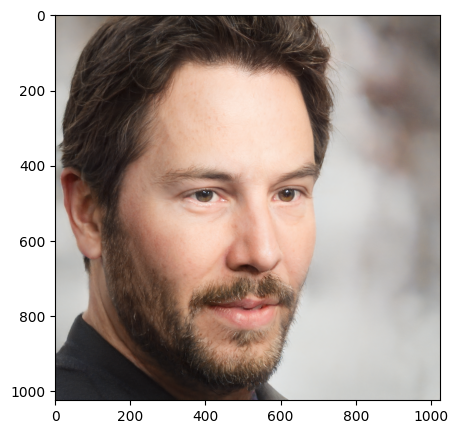

In [11]:
generated_tensor = G.synthesis(initial_latent_vector, noise_mode='const', force_fp32=True)
plot_image(generated_tensor, (5,5))

In [30]:
import torch.nn as nn
from tqdm import tqdm


num_steps = 100
learning_rate = 0.01
initial_latent_vector = nn.Parameter(initial_latent_vector, requires_grad=True)

optimizer = torch.optim.Adam([initial_latent_vector], lr=learning_rate)
generated_tensors = []
for step in tqdm(range(num_steps)):
    synth_tensor = G.synthesis(initial_latent_vector, noise_mode="const")

    lpips_value = lpips_loss(synth_tensor, target_tensor)
    rec_value = rec_loss(synth_tensor, target_tensor)
    reg_value = reg_loss()

    loss = (
        lpips_value * lpips_weoght
        + rec_value * rec_weight
        + reg_value * regularize_noise_weight
    )

    optimizer.step()
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    generated_tensors.append(synth_tensor)

generated_tensor = G.synthesis(
    initial_latent_vector, noise_mode="const", force_fp32=True
)

# save_image(generated_tensor, path="./projected_image.png")
print(loss.item())

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:45<00:00,  2.21it/s]

114595.4453125


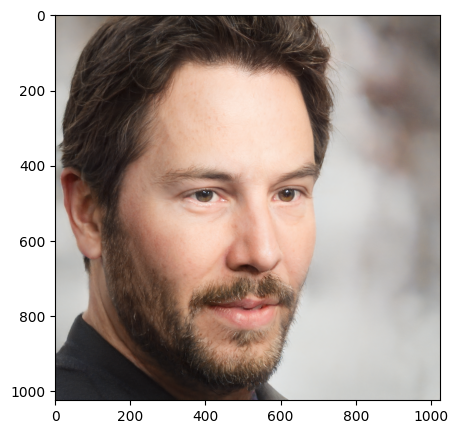

In [12]:
plot_image(generated_tensor, plot_size=(5,5))

In [38]:
video_path = "../proj_video_e4e.mp4"
save_video(video_path)

Saving optimization progress video ../proj_video_e4e.mp4


## Plot latent using PCA


In [15]:
import os
import glob
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


images_path = "/Users/pavelvyaznikov/Documents/itmo_gan_course/aligned_images"
save_path = "/Users/pavelvyaznikov/Documents/itmo_gan_course/4e_invertion"

data = []
for persone in sorted(os.listdir(images_path)):
    person_images = os.path.join(images_path, persone)
    save_folder = os.path.join(save_path, persone)
    os.makedirs(save_folder, exist_ok=True)

    for image_name in os.listdir(person_images):
      image_path = os.path.join(person_images, image_name)

      target_pil = Image.open(image_path).convert('RGB')
      target_uint8 = np.array(target_pil, dtype=np.uint8)

      e4e_tensor = image2e4etensor(target_uint8).to(device).unsqueeze(0)

      latent_vector = e4e_model(e4e_tensor).detach().cpu()
      latent_path = os.path.join(save_folder, f"{image_name[:-4]}.pt")

      torch.save(latent_vector, latent_path)
      data.append([persone, image_name, image_path, latent_path])

df = pd.DataFrame(data, columns = ['key', 'image_name', 'image_path', 'latent_path'])

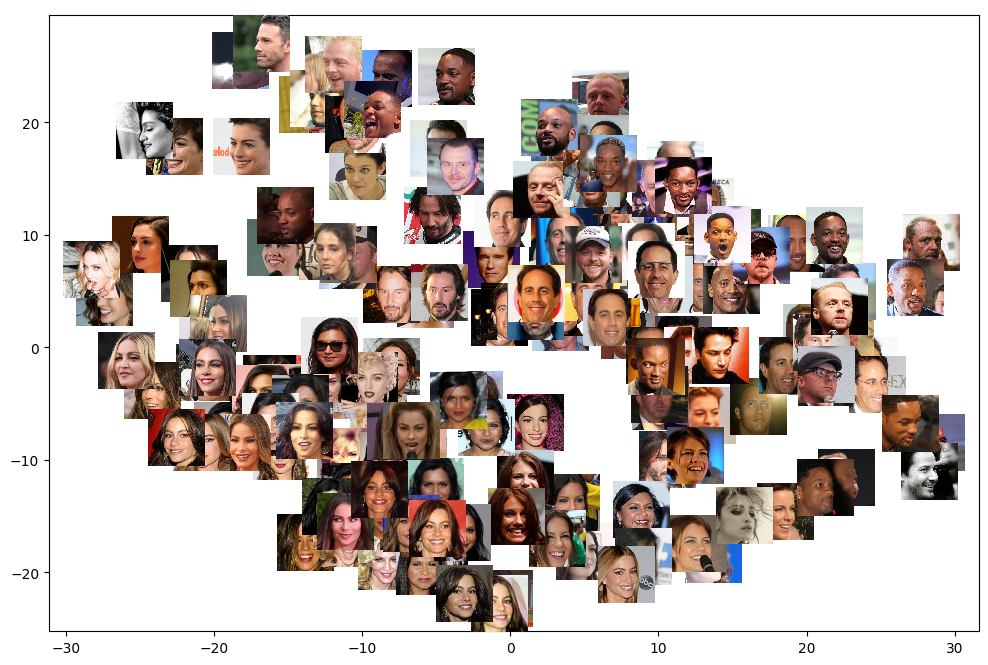

In [16]:
def getImage(path, zoom=0.04):
    return OffsetImage(plt.imread(path), zoom=zoom)

embedings = []
for index, row in df.iterrows():
    latent_path = row["latent_path"]
    latent = torch.load(latent_path).numpy().squeeze(0)
    embedings.append(latent)

batch = np.stack(embedings, axis=0)
batch = batch.reshape((182, 9216))
pca = PCA(n_components=2, random_state=22).fit(batch)
x = pca.transform(batch)

fig, ax = plt.subplots(figsize=(12,8))
# for x, y, path in zip(x[:, 0], x[:, 1], df.image_path.values.tolist()):
for x, y, df_iter in zip(x[:, 0], x[:, 1], df.iterrows()):
  i, row = df_iter
  path = row["image_path"]
  label = row["key"]
  ab = AnnotationBbox(getImage(path), (x, y), frameon=False)
  ax.add_artist(ab)
  plt.scatter(x,y, label=label)

# plt.legend()
plt.show()

## Interpolation and editing

In [17]:
import torch


def interpolate(latent1, latent2, psi=0.5, indeces=[i for i in range(0,18)]):
    init_latent = latent1.clone()
    latent1 = latent1.clone()
    latent2 = latent2.clone()
    for i in indeces:
        latent1[:, i] = latent2[:, i].lerp(latent1[:, i], psi)

    edited_tensor = G.synthesis(latent1, noise_mode='const', force_fp32=True)
    init_tensor = G.synthesis(init_latent, noise_mode='const', force_fp32=True)
    plot_image(torch.cat((init_tensor, edited_tensor ), dim=3), (10,10))


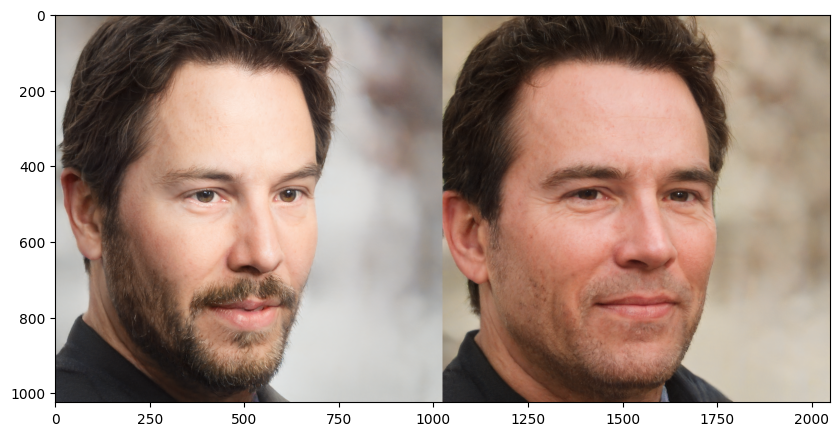

In [23]:
latent1=torch.load("/Users/pavelvyaznikov/Documents/itmo_gan_course/4e_invertion/keanu_reeves/3.pt").to(device)
latent2=torch.load("/Users/pavelvyaznikov/Documents/itmo_gan_course/4e_invertion/arnold_schwarzenegger/1.pt").to(device)

interpolate(latent1, latent2, psi=0.45)

torch.Size([1, 18, 512])


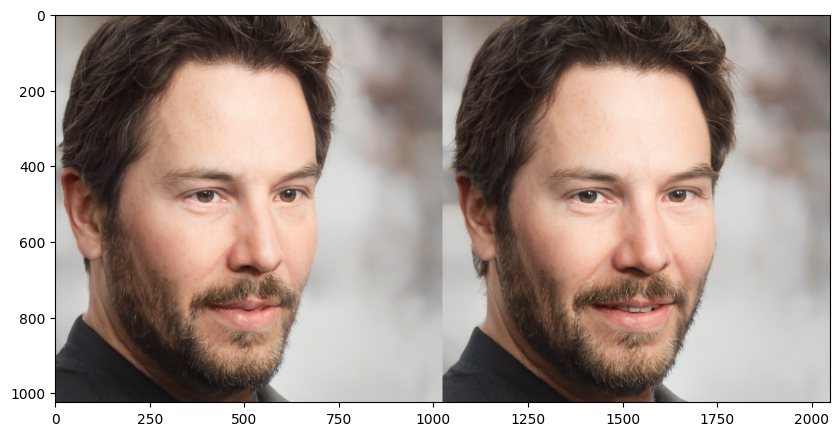

In [78]:
latent1 = torch.load("/Users/pavelvyaznikov/Documents/itmo_gan_course/4e_invertion/keanu_reeves/3.pt").to(device)
print(latent1.shape)
# latent1 = initial_latent_vector

# latent2=torch.load("/Users/pavelvyaznikov/Documents/itmo_gan_course/editing/age.pt").to(device)
latent2 = torch.load("/Users/pavelvyaznikov/Documents/itmo_gan_course/editing/smile.pt").to(device)
latent2 = broadcast_w_sg(latent2)

indeces = list(range(5))
interpolate(latent1, latent2, psi=0.75, indeces=indeces)

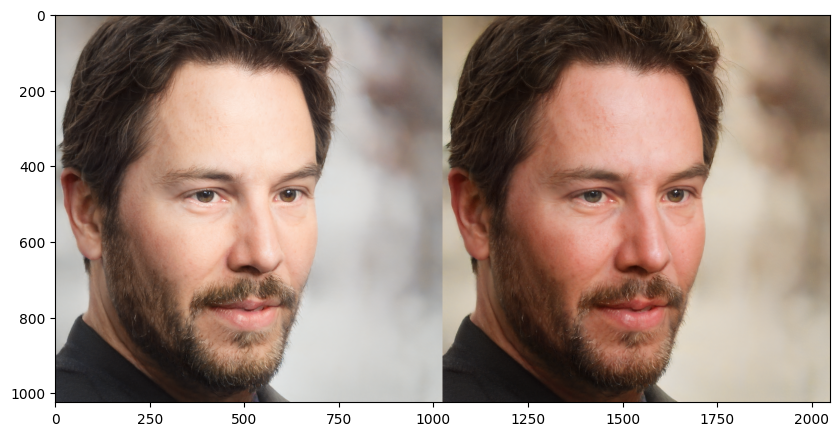

In [73]:
latent1 = torch.load("/Users/pavelvyaznikov/Documents/itmo_gan_course/4e_invertion/keanu_reeves/3.pt").to(device)
latent2 = torch.load("/Users/pavelvyaznikov/Documents/itmo_gan_course/4e_invertion/arnold_schwarzenegger/1.pt").to(device)

indeces = list(range(10, 18))
interpolate(latent1, latent2, psi=0.3, indeces=indeces)

# Homework

In [ ]:
file_id = '1QIPdkYyIwqEUS8jBNouWo9eYzr3DwDd5' # URL id.
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('ms1mv3_arcface_r50_fp16.pth')


In [85]:
import PIL
import os
import numpy as np
import torch
import lpips
import torch.nn as nn
import torchvision.transforms as transforms
from pytorch_msssim import ms_ssim
from stylegan2_ada_pytorch.stylegan2_models.arcface_model import get_model
import torch.nn.functional as F
import torchvision.transforms as transforms


def image2tensor_norm(image):
    transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    tensor = transform(image)
    return tensor


class Arcface_Loss(nn.Module):
    def __init__(self, weights_path, device):
        super().__init__()

        self.arcnet = get_model("r50", fp16=False)
        self.arcnet.load_state_dict(torch.load(weights_path, map_location=device))
        self.arcnet.eval()
        self.arcnet.to(device)

        self.cosin_loss = nn.CosineSimilarity(dim=1, eps=1e-6)

    def forward(self, source, synth):
        source = F.interpolate(source,size=(112,112), mode='bicubic')
        synth = F.interpolate(synth,size=(112,112), mode='bicubic')

        emb1 = self.arcnet(source)
        emb2 = self.arcnet(synth)
        loss = (1 - self.cosin_loss(emb1, emb2))[0]
        return loss

device = "cpu"

arcface_path = "/Users/pavelvyaznikov/Documents/itmo_gan_course/stylegan2_ada_pytorch/ms1mv3_arcface_r50_fp16.pth"
attr_path  = "/Users/pavelvyaznikov/Documents/itmo_gan_course/aligned_images/keanu_reeves/3.jpg"
id_path = "/Users/pavelvyaznikov/Documents/itmo_gan_course/aligned_images/arnold_schwarzenegger/1.jpg"


target_pil = Image.open(attr_path).convert("RGB")
arcface_pil = Image.open(id_path).convert("RGB")
target_tensor = image2tensor_norm(target_pil).to(device).unsqueeze(0)
arcface_tensor = image2tensor_norm(arcface_pil).to(device).unsqueeze(0)

# инициализируем функции потерь
lpips_loss = Lpips_loss(device)
rec_loss = Rec_loss()
arcface_loss = Arcface_Loss(arcface_path, device)

noise_bufs = {
    name: buf for (name, buf) in G.synthesis.named_buffers() if "noise_const" in name
}
reg_loss = Reg_loss(noise_bufs)

regularize_noise_weight = 5e5
rec_weight = 0.5
lpips_weoght = 1
arcface_weoght = 1

# Параметры для оптимизации
num_steps = 150
seed = 42
initial_learning_rate = 0.05
w_avg_samples = 10000

# Получаем средний вектор латентного пространства
z_samples = (
    torch.from_numpy(np.random.RandomState(seed).randn(w_avg_samples, G.z_dim))
    .type(torch.float32)
    .to(device)
)
w_samples = G.mapping(z_samples, None)
w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)
w_avg = np.mean(w_samples, axis=0, keepdims=True)  # [1, 1, C]
w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

# w or w_plus
w_opt = torch.tensor(
    w_avg, dtype=torch.float32, device=device, requires_grad=False
)  # pylint: disable=not-callable
w_opt = broadcast_w_sg(w_opt).requires_grad_(True)

optimizer = torch.optim.Adam([w_opt], lr=initial_learning_rate)
generated_tensors = []
for step in tqdm(range(num_steps)):
    synth_tensor = G.synthesis(broadcast_w_sg(w_opt), noise_mode="const")

    lpips_value = lpips_loss(synth_tensor, target_tensor)
    rec_value = rec_loss(synth_tensor, target_tensor)
    reg_value = reg_loss()
    arcface_value = arcface_loss(arcface_tensor, synth_tensor)

    loss = (
        lpips_value * lpips_weoght
        + rec_value * rec_weight
        + reg_value * regularize_noise_weight
        + arcface_value * arcface_weoght
    )

    optimizer.step()
    optimizer.zero_grad(set_to_none=True)
    loss.backward()

    generated_tensors.append(synth_tensor)

generated_tensor = G.synthesis(
    broadcast_w_sg(w_opt), noise_mode="const", force_fp32=True
)

# save_image(generated_tensor, path="./projected_image.png")
print(loss.item())


"""
  1 Взять 6 фотографии, наборе должны быть хотя бы 2 фото с разным поворотом головы
   - Делаем style transfer
   - Замена лиц с новым Arcface лоссом

  2. Expression Transfer

"""


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /Users/pavelvyaznikov/Documents/itmo_gan_course/venv/lib/python3.11/site-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/150 [00:00<?, ?it/s]